<a href="https://colab.research.google.com/github/Rishad-A-Pulok/Sign_Langugae_ASL/blob/main/ASL_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
!unzip "/content/drive/MyDrive/Sign Language Project/asl-full.zip"

Streaming output truncated to the last 5000 lines.
  inflating: asl-full/validation/S/S2809.jpg  
  inflating: asl-full/validation/S/S2810.jpg  
  inflating: asl-full/validation/S/S2811.jpg  
  inflating: asl-full/validation/S/S2812.jpg  
  inflating: asl-full/validation/S/S2813.jpg  
  inflating: asl-full/validation/S/S2814.jpg  
  inflating: asl-full/validation/S/S2815.jpg  
  inflating: asl-full/validation/S/S2816.jpg  
  inflating: asl-full/validation/S/S2817.jpg  
  inflating: asl-full/validation/S/S2818.jpg  
  inflating: asl-full/validation/S/S2819.jpg  
  inflating: asl-full/validation/S/S2820.jpg  
  inflating: asl-full/validation/S/S2821.jpg  
  inflating: asl-full/validation/S/S2822.jpg  
  inflating: asl-full/validation/S/S2823.jpg  
  inflating: asl-full/validation/S/S2824.jpg  
  inflating: asl-full/validation/S/S2825.jpg  
  inflating: asl-full/validation/S/S2826.jpg  
  inflating: asl-full/validation/S/S2827.jpg  
  inflating: asl-full/validation/S/S2828.jpg  
  inflati

In [4]:
# input path for the images
base_path = '/content/asl-full/train/'

In [5]:
SIZE = 224
image_size = (SIZE, SIZE)
batch_size = 32
channels = 3
kernel = 4
stride = 1
pool = 2

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)

Found 69600 files belonging to 29 classes.
Using 55680 files for training.
Found 69600 files belonging to 29 classes.
Using 13920 files for validation.


In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip= True,
    vertical_flip= False,
    validation_split= 0.2,
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split= 0.2,
)

In [8]:
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
)
test_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = False,
    subset = 'validation'
)

Found 55680 images belonging to 29 classes.
Found 13920 images belonging to 29 classes.


In [9]:
test_set.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [11]:
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

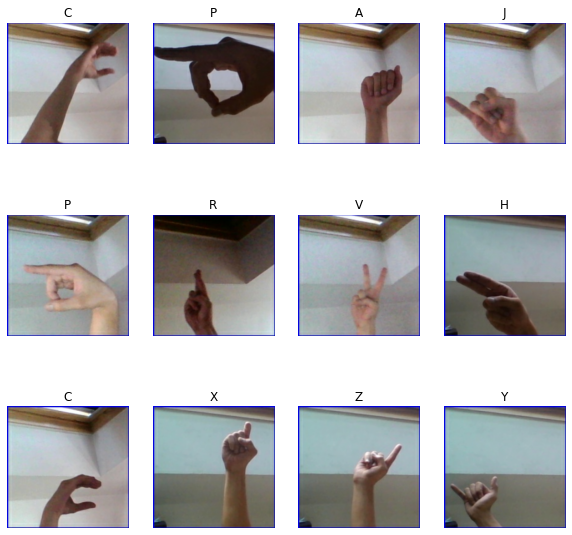

In [12]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

#ResNet50 Model

In [13]:
resnet50v2 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

94668760/94668760 [==============================] - 0s 0us/step


In [14]:
for layer in resnet50v2.layers:
    layer.trainable = False

In [23]:
standard_classifier = tf.keras.Sequential()
standard_classifier.add(layers.Flatten())
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.Dense(29))
standard_classifier.add(layers.Activation('softmax'))

In [24]:
model = tf.keras.Sequential([
  resnet50v2,
  standard_classifier
])

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 sequential_2 (Sequential)   (None, 29)                10439637  
                                                                 
Total params: 34,004,437
Trainable params: 10,238,933
Non-trainable params: 23,765,504
_________________________________________________________________


In [19]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 33.9 MB/s 


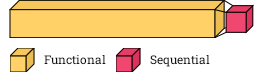

In [27]:
from PIL import ImageFont
import visualkeras
font = ImageFont.truetype("/content/drive/MyDrive/Sign Language Project/RobotoSlab-VariableFont_wght.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font)

In [28]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
history = model.fit(
  train_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set),
  callbacks=model_checkpoint,
)

Epoch 1/15
1740/1740 [==============================] - 768s 439ms/step - loss: 0.6374 - accuracy: 0.8608 - val_loss: 2.4706 - val_accuracy: 0.7174
Epoch 2/15
1740/1740 [==============================] - 758s 436ms/step - loss: 0.2518 - accuracy: 0.9474 - val_loss: 2.5173 - val_accuracy: 0.7588
Epoch 3/15
1740/1740 [==============================] - 754s 433ms/step - loss: 0.2012 - accuracy: 0.9624 - val_loss: 2.7980 - val_accuracy: 0.7631
Epoch 4/15
1740/1740 [==============================] - 760s 437ms/step - loss: 0.1781 - accuracy: 0.9689 - val_loss: 3.3629 - val_accuracy: 0.7633
Epoch 5/15
1740/1740 [==============================] - 755s 434ms/step - loss: 0.1685 - accuracy: 0.9739 - val_loss: 3.8244 - val_accuracy: 0.7694
Epoch 6/15
1740/1740 [==============================] - 756s 434ms/step - loss: 0.1438 - accuracy: 0.9779 - val_loss: 4.1669 - val_accuracy: 0.7746
Epoch 7/15
1740/1740 [==============================] - 756s 434ms/step - loss: 0.1324 - accuracy: 0.9805 - val_

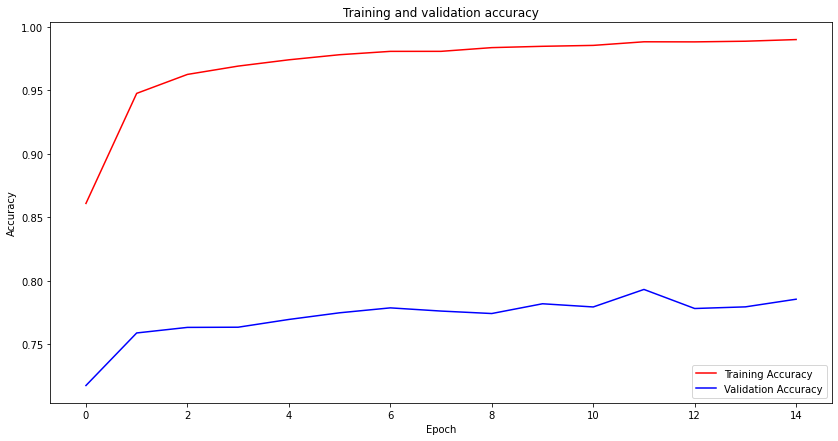

In [30]:
# Validation and Training accuracy plot
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

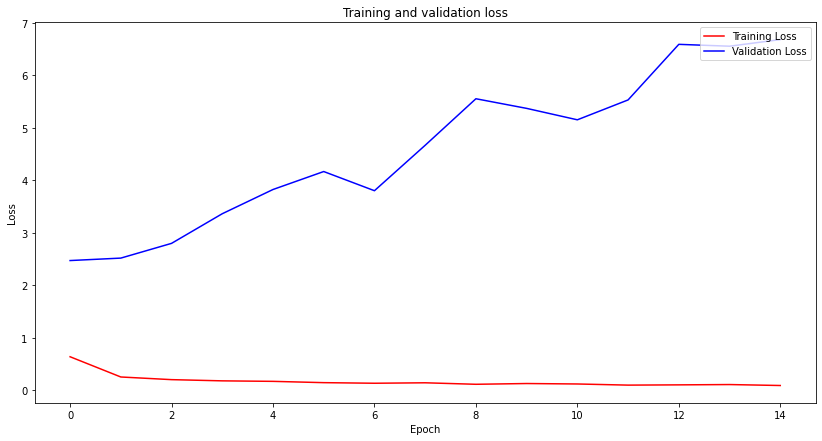

In [31]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


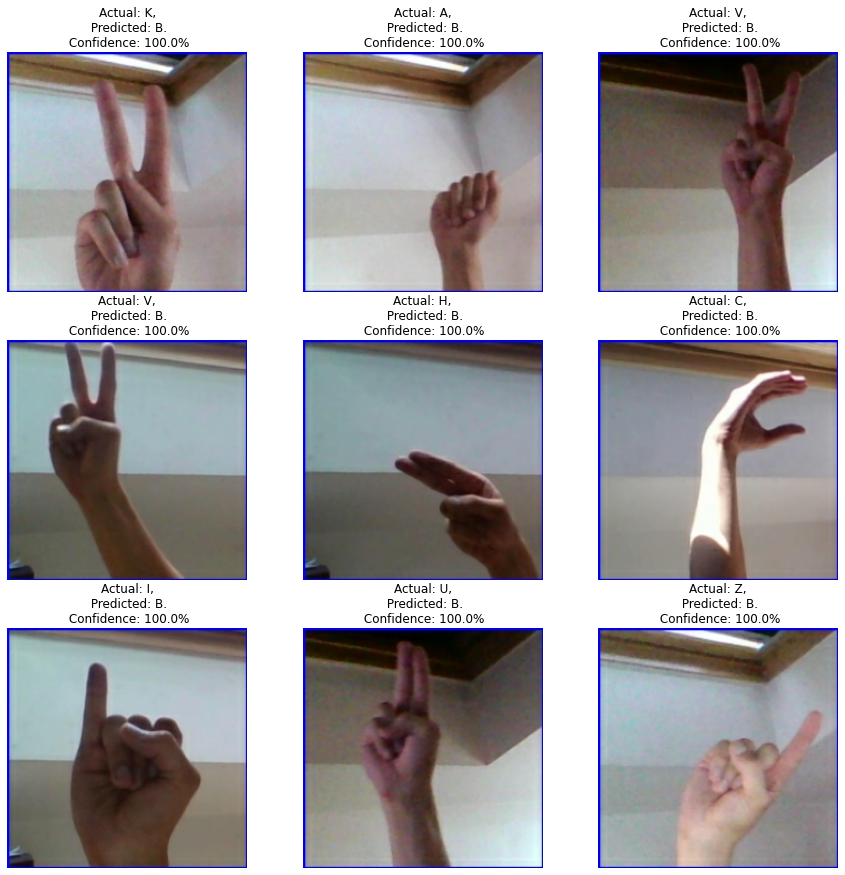

In [33]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence =predict(model, image_batch[i].numpy())
        actual_class = class_names[labels_batch[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [34]:
loss,test_accuracy = model.evaluate(test_set)
print('Accuracy on test:', test_accuracy)

435/435 [==============================] - 149s 342ms/step - loss: 6.6703 - accuracy: 0.7836
Accuracy on test: 0.7836207151412964


In [35]:
# T0 print the Classification Report
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_set.classes, y_pred))

435/435 [==============================] - 150s 343ms/step
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       480
           1       0.95      0.93      0.94       480
           2       0.95      0.80      0.87       480
           3       0.97      0.78      0.87       480
           4       0.78      0.81      0.80       480
           5       0.92      0.99      0.95       480
           6       0.87      0.92      0.90       480
           7       0.92      0.94      0.93       480
           8       0.82      0.66      0.73       480
           9       0.86      0.80      0.83       480
          10       0.84      0.76      0.80       480
          11       0.82      0.98      0.90       480
          12       0.71      0.94      0.81       480
          13       0.74      0.59      0.66       480
          14       0.73      0.59      0.65       480
          15       0.87      0.82      0.84       480
          16       0.9

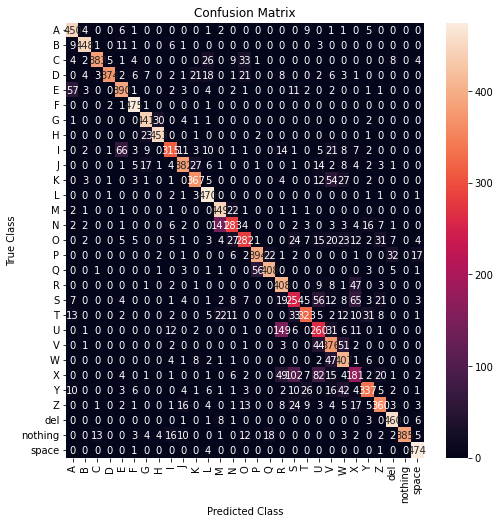

In [36]:
import seaborn as sns
# To print the Confusion Matrix
cf_matrix = confusion_matrix(test_set.classes, y_pred)
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()